40022
RMSE: 0.49112457036972046 rate : 0.01 iter : 1000


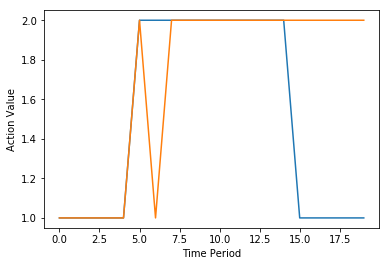

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import socket
import sys

tf.set_random_seed(777)  # reproducibility

if "DISPLAY" not in os.environ:
    matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline

def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

 
TCP_IP = '127.0.0.1'
TCP_PORT = 9999
BUFFER_SIZE = 1024
MESSAGE = 'Hello, World!'
 
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect((TCP_IP, TCP_PORT))
message = 'Connected'
sock.sendall(message.encode('utf-8'))

# train Parameters
seq_length = 4
data_dim = 24
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 1000

xy = np.loadtxt('./data/out/total_test.csv', delimiter=',')
#xy = xy[::-1]  # reverse order (chronically ordered)

x = xy[:, 0:24]
nor_min = np.min(x, 0) 
nor_den = np.max(x, 0) - np.min(x, 0) 

x = MinMaxScaler(x)
y = xy[:, [-1]]  

# build a dataset
dataX = []
dataY = []
cnt = 0

for i in range(0, len(y) ,seq_length): 
    _x = x[i:i + seq_length] 
    _y = y[i + seq_length - 1]  # Present label
    
    dataX.append(_x)
    dataY.append(_y)
    
# train/test split
print(len(dataY))
    
train_size = 40002

test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        message = "[step: {}] loss: {}\n".format(i, step_loss)
        sock.sendall(message.encode('utf-8'))
        #print("[step: {}] loss: {}".format(i, step_loss))
  

    # Validate Process
    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {} rate : {} iter : {}".format(rmse_val,learning_rate ,iterations )) # 표준 편차 (차이가 안날수록 좋음)
    
    test_int = []
    for j in range(len(test_predict)):
        test_int.append(int(test_predict[j] + 0.5) )

    
    #print(test_int)
    
    # Plot predictions|
    plt.plot(testY)
    #plt.plot(test_predict)
    plt.plot(test_int)
    #print(test_predict)
    
    #test_integer = test_predict[0] + 0.5
    #test_integer = int(test_integer)
    #print(test_integer)
    #plt.plot(test_integer)

    #print(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Action Value")
    plt.show()
    message = "R\n"
    sock.sendall(message.encode('utf-8'))
        
    while True:
        dataX_t = []
        input_integer = sock.recv(BUFFER_SIZE)
        input_str = sock.recv(BUFFER_SIZE)
        s_data = input_str.split(','.encode('utf-8'))
        i_data = [float (i) for i in s_data]
        i_data = np.reshape(i_data, (seq_length, 24))
        
        _numerator = i_data - nor_min
        i_data =  _numerator / (nor_den + 1e-7)
        print(i_data)
        dataX_t.append(i_data)
        input_t = np.array(dataX_t[0:1])        
        test_predict = sess.run(Y_xspred, feed_dict={X: input_t})
        print(test_predict)
        message = "{}\n".format(test_predict[0][0])
        sock.sendall(message.encode('utf-8'))

sock.close()
